# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, f1_score
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix,roc_curve, auc,f1_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

import re
from bs4 import BeautifulSoup
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('./dataset/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

def findMinorClassPoints(df):
    posCount = df[df['Score']==1].shape[0];
    negCount = df[df['Score']==0].shape[0];
    if negCount < posCount:
        return negCount
    return posCount

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

#Performing Downsampling
samplingCount = findMinorClassPoints(filtered_data)
postive_df = filtered_data[filtered_data['Score'] == 1].sample(n=samplingCount)
negative_df = filtered_data[filtered_data['Score'] == 0].sample(n=samplingCount)

filtered_data = pd.concat([postive_df, negative_df])

print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (164074, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
451137,487779,B000LKTJ9C,A3PAMF9DX1QWO6,Elf,0,0,1,1279584000,Pumpkin seeds,I absolutely love these seeds.<br />They are t...
251383,272549,B007OXJL0G,AZQA8ZIGS01FG,teejay,0,0,1,1333152000,good coffee,I love this coffee it is one of my favorites. ...
164676,178590,B005GYJUK6,A360V40BYDEUVQ,&quot;Tuttie&quot;,1,1,1,1349049600,Sugar-Free Torani Peach--a fun flavoring!,"Peach is one of my favorite flavors in life, s..."


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(128427, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

78.27382766312762

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(128427, 10)


1    71317
0    57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

These days, when a person says, "chicken soup" they're probably going to follow up those words with, "for the soul" or maybe "for the teenaged soul".  Didn't used to be that way.  Why I can remember a time when if a person said, "chicken soup" those words were followed by an enthusiastic "with rice!".  Such was the power of Maurice Sendak's catchy 1962 children's book.  I am pleased to report that if you care to read this book again today, you will find it hasn't dimished a jot in terms of frolicksome fun.  In this book we are led through a whirlwind chicken soup year with our host, a boy who bears no little resemblance to Sendak's other great rhyming tale "Pierre" (in looks if not demeanor).  It's a catchy flouncy bouncy combo of soup and the people who love it so.<br /><br />This is ostensibly a book meant to teach your children the different months of the year.  Each month gets its own rhythmic poem and accompanying illustration.  These are fairly simple pen and ink drawings with th

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

These days, when a person says, "chicken soup" they're probably going to follow up those words with, "for the soul" or maybe "for the teenaged soul".  Didn't used to be that way.  Why I can remember a time when if a person said, "chicken soup" those words were followed by an enthusiastic "with rice!".  Such was the power of Maurice Sendak's catchy 1962 children's book.  I am pleased to report that if you care to read this book again today, you will find it hasn't dimished a jot in terms of frolicksome fun.  In this book we are led through a whirlwind chicken soup year with our host, a boy who bears no little resemblance to Sendak's other great rhyming tale "Pierre" (in looks if not demeanor).  It's a catchy flouncy bouncy combo of soup and the people who love it so.<br /><br />This is ostensibly a book meant to teach your children the different months of the year.  Each month gets its own rhythmic poem and accompanying illustration.  These are fairly simple pen and ink drawings with th

In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

These days, when a person says, "chicken soup" they're probably going to follow up those words with, "for the soul" or maybe "for the teenaged soul".  Didn't used to be that way.  Why I can remember a time when if a person said, "chicken soup" those words were followed by an enthusiastic "with rice!".  Such was the power of Maurice Sendak's catchy 1962 children's book.  I am pleased to report that if you care to read this book again today, you will find it hasn't dimished a jot in terms of frolicksome fun.  In this book we are led through a whirlwind chicken soup year with our host, a boy who bears no little resemblance to Sendak's other great rhyming tale "Pierre" (in looks if not demeanor).  It's a catchy flouncy bouncy combo of soup and the people who love it so.This is ostensibly a book meant to teach your children the different months of the year.  Each month gets its own rhythmic poem and accompanying illustration.  These are fairly simple pen and ink drawings with the occasional

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Picture a straight stick, lopped off at the top, with a few bare branches a few tiny bits of green, and you have this "bonsai" plant. Very well packed, but pathetic when unpacked, the only resemblance to the photos on the Amazon page would be the pot, which is identical. We received this as sympathy gift after death in family. Hard to imagine a more absurd item. Noted this to the sender, who apparently complained and got a second sent, very similar to the first. Deceptive photo, this item needs a strong disclaimer against use as a gift.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

These days, when a person says, "chicken soup" they're probably going to follow up those words with, "for the soul" or maybe "for the teenaged soul".  Didn't used to be that way.  Why I can remember a time when if a person said, "chicken soup" those words were followed by an enthusiastic "with rice!".  Such was the power of Maurice Sendak's catchy  children's book.  I am pleased to report that if you care to read this book again today, you will find it hasn't dimished a jot in terms of frolicksome fun.  In this book we are led through a whirlwind chicken soup year with our host, a boy who bears no little resemblance to Sendak's other great rhyming tale "Pierre" (in looks if not demeanor).  It's a catchy flouncy bouncy combo of soup and the people who love it so.<br /><br />This is ostensibly a book meant to teach your children the different months of the year.  Each month gets its own rhythmic poem and accompanying illustration.  These are fairly simple pen and ink drawings with the oc

In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Picture a straight stick lopped off at the top with a few bare branches a few tiny bits of green and you have this bonsai plant Very well packed but pathetic when unpacked the only resemblance to the photos on the Amazon page would be the pot which is identical We received this as sympathy gift after death in family Hard to imagine a more absurd item Noted this to the sender who apparently complained and got a second sent very similar to the first Deceptive photo this item needs a strong disclaimer against use as a gift 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 128427/128427 [00:50<00:00, 2548.79it/s]


In [23]:
preprocessed_reviews[1500]

'picture straight stick lopped top bare branches tiny bits green bonsai plant well packed pathetic unpacked resemblance photos amazon page would pot identical received sympathy gift death family hard imagine absurd item noted sender apparently complained got second sent similar first deceptive photo item needs strong disclaimer use gift'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
## Similartly you can do preprocessing for review summary also.
def concatenateSummaryWithText(str1, str2):
    return str1 + ' ' + str2

preprocessed_summary = []
# tqdm is for printing the status bar
for sentence in tqdm(final['Summary'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    #sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentence.strip())
    
preprocessed_reviews = list(map(concatenateSummaryWithText, preprocessed_reviews, preprocessed_summary))
final['CleanedText'] = preprocessed_reviews
final['CleanedText'] = final['CleanedText'].astype('str')

100%|██████████| 128427/128427 [00:02<00:00, 50626.94it/s]


# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
# #BoW
# count_vect = CountVectorizer() #in scikit-learn
# count_vect.fit(preprocessed_reviews)
# print("some feature names ", count_vect.get_feature_names()[:10])
# print('='*50)

# final_counts = count_vect.transform(preprocessed_reviews)
# print("the type of count vectorizer ",type(final_counts))
# print("the shape of out text BOW vectorizer ",final_counts.get_shape())
# print("the number of unique words ", final_counts.get_shape()[1])

## [4.2] Bi-Grams and n-Grams.

In [26]:
# #bi-gram, tri-gram and n-gram

# #removing stop words like "not" should be avoided before building n-grams
# # count_vect = CountVectorizer(ngram_range=(1,2))
# # please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# # you can choose these numebrs min_df=10, max_features=5000, of your choice
# count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
# final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
# print("the type of count vectorizer ",type(final_bigram_counts))
# print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
# print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

## [4.3] TF-IDF

In [27]:
# tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
# tf_idf_vect.fit(preprocessed_reviews)
# print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
# print('='*50)

# final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
# print("the type of count vectorizer ",type(final_tf_idf))
# print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
# print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

## [4.4] Word2Vec

In [28]:
# # Train your own Word2Vec model using your own text corpus
# i=0
# list_of_sentance=[]
# for sentance in preprocessed_reviews:
#     list_of_sentance.append(sentance.split())

In [29]:
# # Using Google News Word2Vectors

# # in this project we are using a pretrained model by google
# # its 3.3G file, once you load this into your memory 
# # it occupies ~9Gb, so please do this step only if you have >12G of ram
# # we will provide a pickle file wich contains a dict , 
# # and it contains all our courpus words as keys and  model[word] as values
# # To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# # from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# # it's 1.9GB in size.


# # http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# # you can comment this whole cell
# # or change these varible according to your need

# is_your_ram_gt_16g=False
# want_to_use_google_w2v = False
# want_to_train_w2v = True

# if want_to_train_w2v:
#     # min_count = 5 considers only words that occured atleast 5 times
#     w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
#     print(w2v_model.wv.most_similar('great'))
#     print('='*50)
#     print(w2v_model.wv.most_similar('worst'))
    
# elif want_to_use_google_w2v and is_your_ram_gt_16g:
#     if os.path.isfile('GoogleNews-vectors-negative300.bin'):
#         w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
#         print(w2v_model.wv.most_similar('great'))
#         print(w2v_model.wv.most_similar('worst'))
#     else:
#         print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

In [30]:
# w2v_words = list(w2v_model.wv.vocab)
# print("number of words that occured minimum 5 times ",len(w2v_words))
# print("sample words ", w2v_words[0:50])

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [31]:
# # average Word2Vec
# # compute average word2vec for each review.
# sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
# for sent in tqdm(list_of_sentance): # for each review/sentence
#     sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
#     cnt_words =0; # num of words with a valid vector in the sentence/review
#     for word in sent: # for each word in a review/sentence
#         if word in w2v_words:
#             vec = w2v_model.wv[word]
#             sent_vec += vec
#             cnt_words += 1
#     if cnt_words != 0:
#         sent_vec /= cnt_words
#     sent_vectors.append(sent_vec)
# print(len(sent_vectors))
# print(len(sent_vectors[0]))

#### [4.4.1.2] TFIDF weighted W2v

In [32]:
# # S = ["abc def pqr", "def def def abc", "pqr pqr def"]
# model = TfidfVectorizer()
# tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# # we are converting a dictionary with word as a key, and the idf as a value
# dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [33]:
# # TF-IDF weighted Word2Vec
# tfidf_feat = model.get_feature_names() # tfidf words/col-names
# # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

# tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
# row=0;
# for sent in tqdm(list_of_sentance): # for each review/sentence 
#     sent_vec = np.zeros(50) # as word vectors are of zero length
#     weight_sum =0; # num of words with a valid vector in the sentence/review
#     for word in sent: # for each word in a review/sentence
#         if word in w2v_words and word in tfidf_feat:
#             vec = w2v_model.wv[word]
# #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
#             # to reduce the computation we are 
#             # dictionary[word] = idf value of word in whole courpus
#             # sent.count(word) = tf valeus of word in this review
#             tf_idf = dictionary[word]*(sent.count(word)/len(sent))
#             sent_vec += (vec * tf_idf)
#             weight_sum += tf_idf
#     if weight_sum != 0:
#         sent_vec /= weight_sum
#     tfidf_sent_vectors.append(sent_vec)
#     row += 1

# [5] Assignment 8: Decision Trees

<ol>
    <li><strong>Apply Decision Trees on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50, 100, 500, 100], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Graphviz</strong>
        <ul>
    <li>Visualize your decision tree with Graphviz. It helps you to understand how a decision is being made, given a new vector.</li>
    <li>Since feature names are not obtained from word2vec related models, visualize only BOW & TFIDF decision trees using Graphviz</li>
    <li>Make sure to print the words in each node of the decision tree instead of printing its index.</li>
    <li>Just for visualization purpose, limit max_depth to 2 or 3 and either embed the generated images of graphviz in your notebook, or directly upload them as .png files.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 20 important features from both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using `feature_importances_` method of <a href='https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html'>Decision Tree Classifier</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Decision Trees

In [34]:
global result_report
result_report = pd.DataFrame(columns=['VECTORIZER', 'DATASET-SIZE', 'MAX-DEPTH(HYPERPARAMETER)', 'MIN_SPLIT(HYPERPARAMETER)', 'F1_SCORE', 'AUC'])

In [35]:
#Sorting according to the time for time-based splitting
final['Time'] = pd.to_datetime(final['Time'], unit='s')
final = final.sort_values(by='Time', ascending=True)

In [36]:
#Using only 100k points for Decision Trees
min_final = final.sample(n=100000)
x_train, x_test, y_train, y_test = train_test_split(min_final['CleanedText'], min_final['Score'], test_size=0.30)

depth_range = [1, 5, 10, 30, 50, 75, 100, 250, 500, 750, 1000]
min_split_range = [5, 10, 50, 100, 500]
tot_hyp_length = np.arange(0, len(depth_range) * len(min_split_range))

## [5.1] Applying Decision Trees on BOW,<font color='red'> SET 1</font>

In [37]:
# Applying BOW Vectorizer
bow_model = CountVectorizer(ngram_range=(1,2), min_df=0.0001, max_features=4000)
bow_model.fit(x_train)

x_train_bow = bow_model.transform(x_train)
x_test_bow = bow_model.transform(x_test)

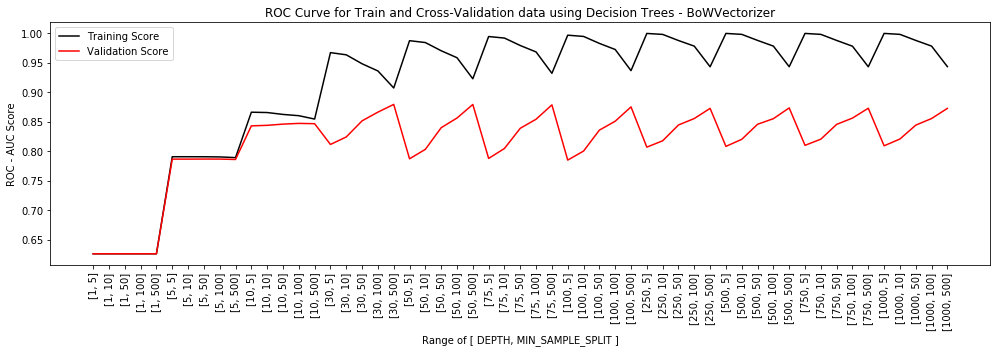

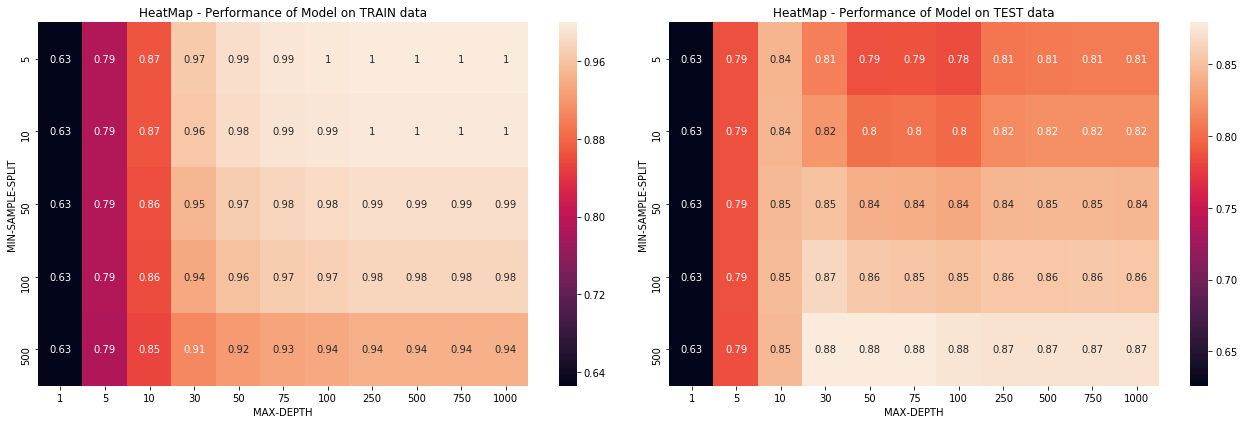

In [38]:
# Applying DecisionTreeClassifier using GridSearch CV=10
dtc = DecisionTreeClassifier()
parameters = {'max_depth': depth_range, 'min_samples_split': min_split_range}
clf = GridSearchCV(dtc, parameters, cv=10, scoring = 'roc_auc', return_train_score=True)
clf.fit(x_train_bow, y_train)

mean_train_score = clf.cv_results_['mean_train_score']
mean_test_score = clf.cv_results_['mean_test_score']

param_arr = list(map(lambda obj: list([obj['max_depth'], obj['min_samples_split']]), clf.cv_results_['params']))

plt.figure(figsize=(14, 5))
#Plot mean accuracy for train and cv set scores
plt.plot(tot_hyp_length, mean_train_score, label='Training Score', color='black')
plt.plot(tot_hyp_length, mean_test_score, label='Validation Score', color='red')
plt.xticks(tot_hyp_length, param_arr, rotation='vertical')

# Create plot
plt.title("ROC Curve for Train and Cross-Validation data using Decision Trees - BoWVectorizer")
plt.xlabel("Range of [ DEPTH, MIN_SAMPLE_SPLIT ]")
plt.ylabel("ROC - AUC Score")
plt.tight_layout()
plt.legend(loc="best")

m_train_score = clf.cv_results_['mean_train_score'].reshape((len(depth_range), len(min_split_range))).T
m_test_score = clf.cv_results_['mean_test_score'].reshape((len(depth_range), len(min_split_range))).T

plt.figure(figsize=(18,6))
plt.subplot(1, 2, 1)
plt.title('HeatMap - Performance of Model on TRAIN data')
ax1 = sns.heatmap(m_train_score, annot=True, xticklabels=depth_range, yticklabels=min_split_range)
ax1.set_xlabel('MAX-DEPTH')
ax1.set_ylabel('MIN-SAMPLE-SPLIT')

plt.subplot(1, 2, 2)
plt.title('HeatMap - Performance of Model on TEST data')
ax2 = sns.heatmap(m_test_score, annot=True, xticklabels=depth_range, yticklabels=min_split_range)
ax2.set_xlabel('MAX-DEPTH')
ax2.set_ylabel('MIN-SAMPLE-SPLIT')

plt.tight_layout()
plt.show()

Optimal Depth: 30 with Min_Split: 500 with AUC: 88.19%


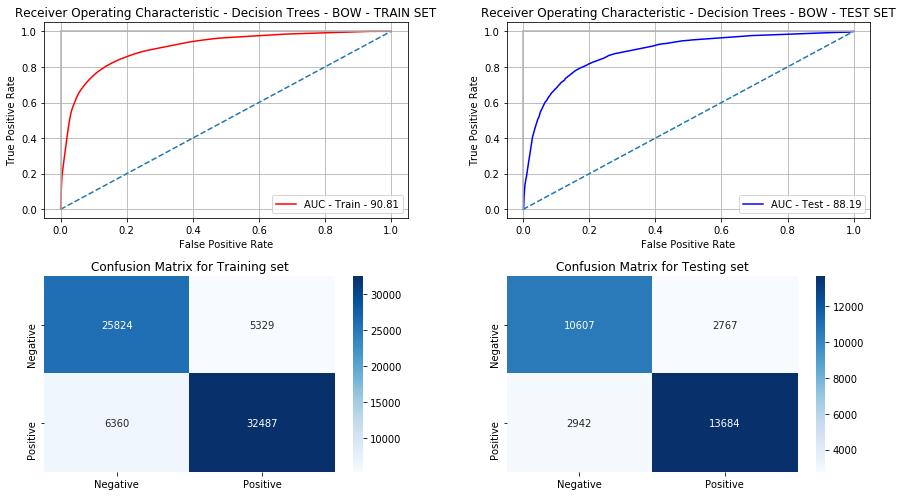

In [39]:
optimal_depth = clf.best_params_['max_depth']
optimal_min_split = clf.best_params_['min_samples_split']

clf = DecisionTreeClassifier(max_depth = optimal_depth, min_samples_split = optimal_min_split)
clf.fit(x_train_bow, y_train)

# Get predicted values for test data
pred_train = clf.predict(x_train_bow)
pred_test = clf.predict(x_test_bow)
pred_proba_train = clf.predict_proba(x_train_bow)[:,1]
pred_proba_test = clf.predict_proba(x_test_bow)[:,1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, pred_proba_train, pos_label=1)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, pred_proba_test, pos_label=1)
conf_mat_train = confusion_matrix(y_train, pred_train, labels=[0, 1])
conf_mat_test = confusion_matrix(y_test, pred_test, labels=[0, 1])
f1_sc = f1_score(y_test, pred_test, average='binary', pos_label=1)
auc_sc_train = auc(fpr_train, tpr_train)
auc_sc = auc(fpr_test, tpr_test)

print("Optimal Depth: {} with Min_Split: {} with AUC: {:.2f}%".format(optimal_depth, optimal_min_split, float(auc_sc*100)))
#Saving the report in a global variable
result_report = result_report.append({'VECTORIZER': 'Bag of Words(BoW)',
                                      'MAX-DEPTH(HYPERPARAMETER)': optimal_depth,
                                      'MIN_SPLIT(HYPERPARAMETER)': optimal_min_split,
                                      'DATASET-SIZE': '{0:,.0f}'.format(int(min_final.shape[0])),
                                      'F1_SCORE': f1_sc, 
                                      'AUC': auc_sc
                                     }, ignore_index=True)


plt.figure(figsize=(13,7))
# Plot ROC curve for training set
plt.subplot(2, 2, 1)
plt.title('Receiver Operating Characteristic - Decision Trees - BOW - TRAIN SET')
plt.plot(fpr_train, tpr_train, color='red', label='AUC - Train - {:.2f}'.format(float(auc_sc_train * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc='best')

# Plot ROC curve for test set
plt.subplot(2, 2, 2)
plt.title('Receiver Operating Characteristic - Decision Trees - BOW - TEST SET')
plt.plot(fpr_test, tpr_test, color='blue', label='AUC - Test - {:.2f}'.format(float(auc_sc * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc='best')

#Plotting the confusion matrix for train
plt.subplot(2, 2, 3)
plt.title('Confusion Matrix for Training set')
df_cm = pd.DataFrame(conf_mat_train, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

#Plotting the confusion matrix for test
plt.subplot(2, 2, 4)
plt.title('Confusion Matrix for Testing set')
df_cm = pd.DataFrame(conf_mat_test, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

plt.tight_layout()
plt.show()

### [5.1.1] Top 20 important features from<font color='red'> SET 1</font>

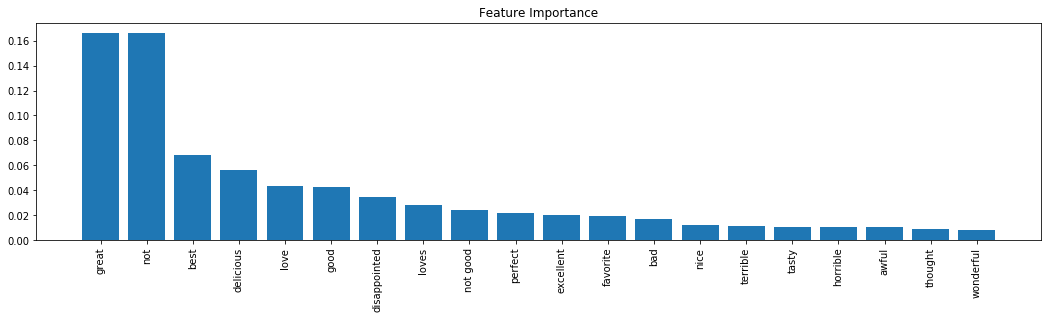

In [40]:
feature_imp_values = clf.feature_importances_
bow_features_names = bow_model.get_feature_names()

indices = np.argsort(feature_imp_values)[::-1]
names = [bow_features_names[i] for i in indices]

# Create plot
plt.figure(figsize=(18,4))
plt.title("Feature Importance")
# Add bars
plt.bar(range(20), feature_imp_values[indices][:20])
# Add feature names as x-axis labels
plt.xticks(range(20), names[:20], rotation=90)
plt.show()

### [5.1.2] Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

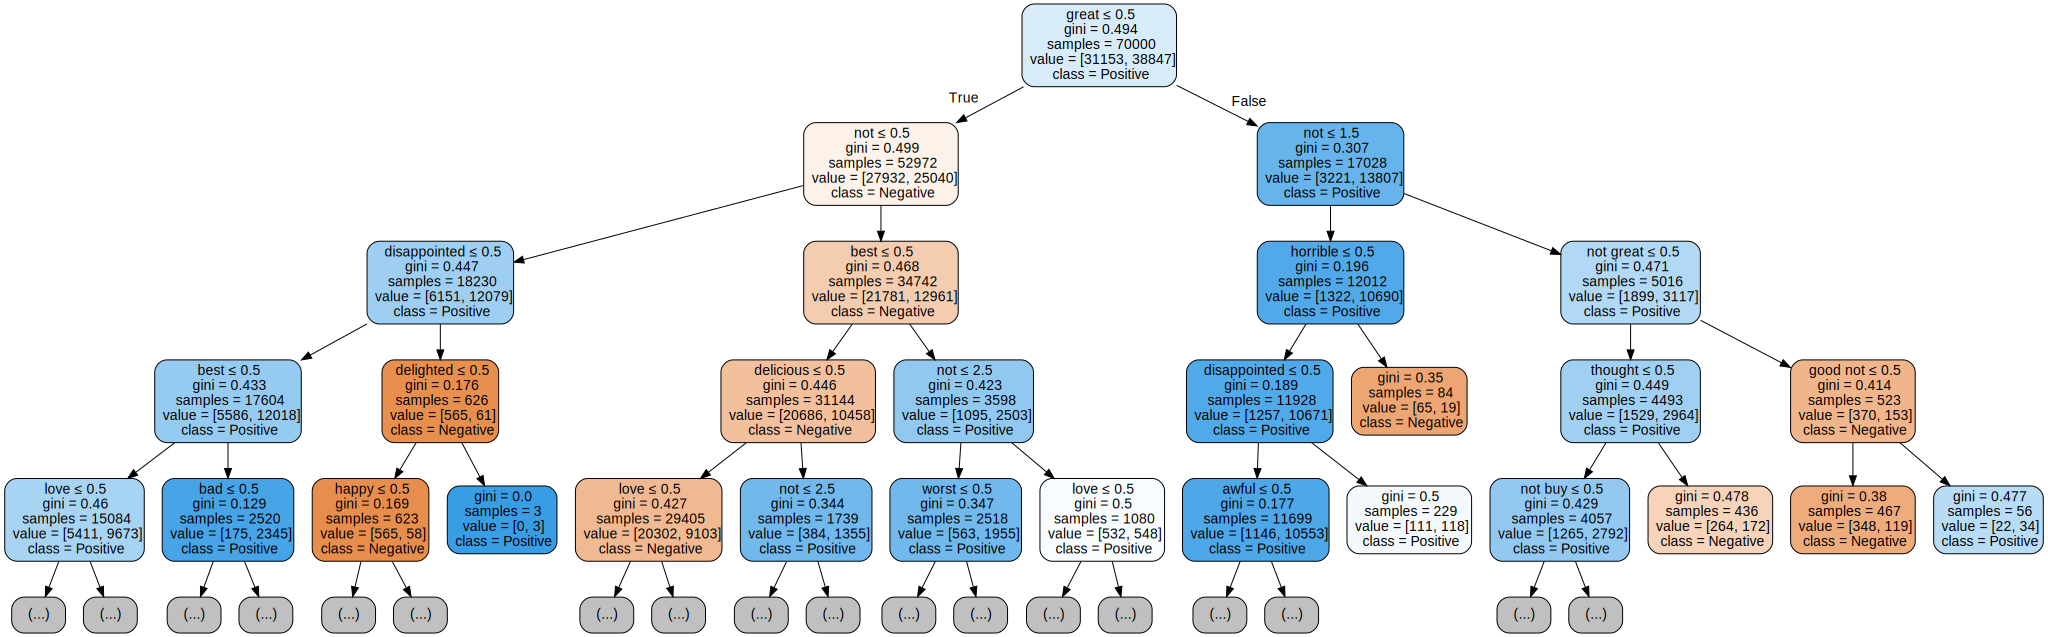

In [41]:
dot_data = export_graphviz(clf, out_file=None, max_depth=4,
                           feature_names=bow_features_names,
                           class_names=["Negative", "Positive"],
                           filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)  
graph.render('graphviz-bow')
graph

## [5.2] Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

In [42]:
# Applying TFIDF Vectorizer
tfidf_model = TfidfVectorizer(ngram_range=(1,2), min_df=0.0001, max_features=4000)
tfidf_model.fit(x_train)

x_train_tfidf = tfidf_model.transform(x_train)
x_test_tfidf = tfidf_model.transform(x_test)

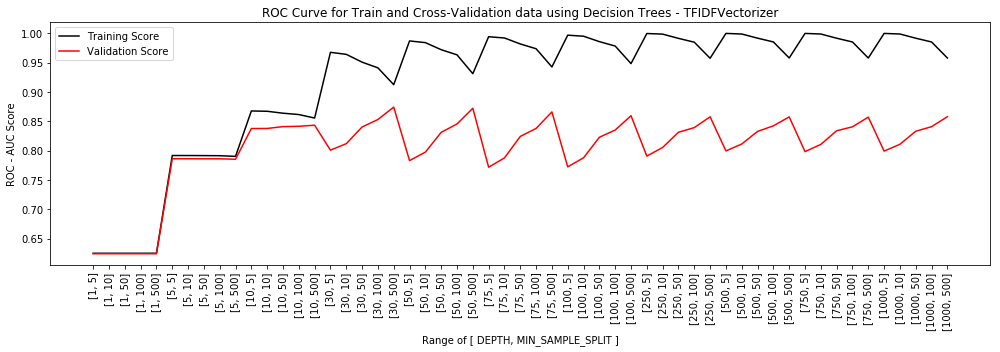

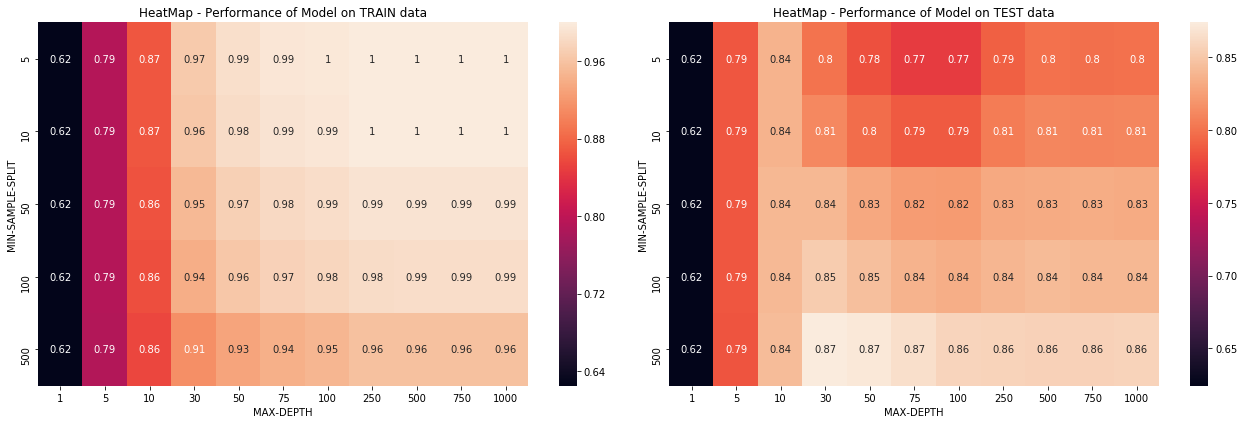

In [43]:
# Applying DecisionTreeClassifier using GridSearch CV=10
dtc = DecisionTreeClassifier()
parameters = {'max_depth': depth_range, 'min_samples_split': min_split_range}
clf = GridSearchCV(dtc, parameters, cv=10, scoring = 'roc_auc', return_train_score=True)
clf.fit(x_train_tfidf, y_train)

mean_train_score = clf.cv_results_['mean_train_score']
mean_test_score = clf.cv_results_['mean_test_score']

param_arr = list(map(lambda obj: list([obj['max_depth'], obj['min_samples_split']]), clf.cv_results_['params']))

plt.figure(figsize=(14, 5))
#Plot mean accuracy for train and cv set scores
plt.plot(tot_hyp_length, mean_train_score, label='Training Score', color='black')
plt.plot(tot_hyp_length, mean_test_score, label='Validation Score', color='red')
plt.xticks(tot_hyp_length, param_arr, rotation='vertical')

# Create plot
plt.title("ROC Curve for Train and Cross-Validation data using Decision Trees - TFIDFVectorizer")
plt.xlabel("Range of [ DEPTH, MIN_SAMPLE_SPLIT ]")
plt.ylabel("ROC - AUC Score")
plt.tight_layout()
plt.legend(loc="best")

m_train_score = clf.cv_results_['mean_train_score'].reshape((len(depth_range), len(min_split_range))).T
m_test_score = clf.cv_results_['mean_test_score'].reshape((len(depth_range), len(min_split_range))).T

plt.figure(figsize=(18,6))
plt.subplot(1, 2, 1)
plt.title('HeatMap - Performance of Model on TRAIN data')
ax1 = sns.heatmap(m_train_score, annot=True, xticklabels=depth_range, yticklabels=min_split_range)
ax1.set_xlabel('MAX-DEPTH')
ax1.set_ylabel('MIN-SAMPLE-SPLIT')

plt.subplot(1, 2, 2)
plt.title('HeatMap - Performance of Model on TEST data')
ax2 = sns.heatmap(m_test_score, annot=True, xticklabels=depth_range, yticklabels=min_split_range)
ax2.set_xlabel('MAX-DEPTH')
ax2.set_ylabel('MIN-SAMPLE-SPLIT')

plt.tight_layout()
plt.show()

Optimal Depth: 30 with Min_Split: 500 with AUC: 87.53%


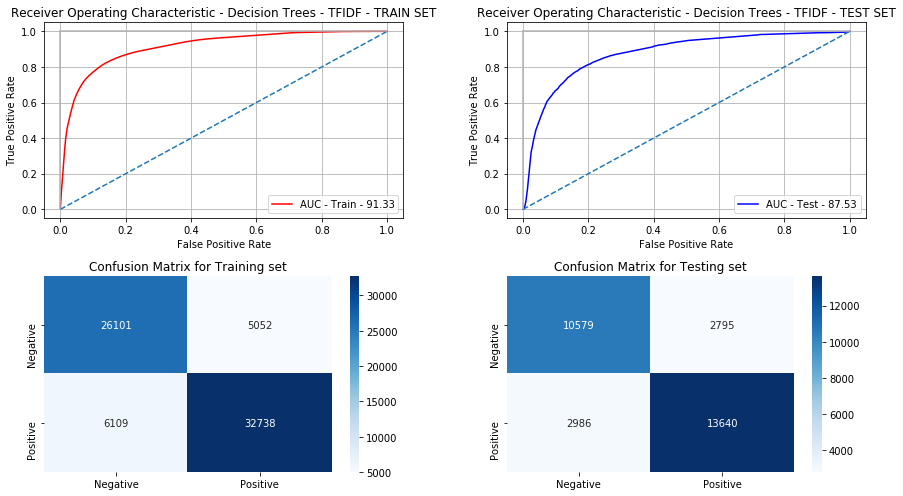

In [44]:
optimal_depth = clf.best_params_['max_depth']
optimal_min_split = clf.best_params_['min_samples_split']

clf = DecisionTreeClassifier(max_depth = optimal_depth, min_samples_split = optimal_min_split)
clf.fit(x_train_tfidf, y_train)

# Get predicted values for test data
pred_train = clf.predict(x_train_tfidf)
pred_test = clf.predict(x_test_tfidf)
pred_proba_train = clf.predict_proba(x_train_tfidf)[:,1]
pred_proba_test = clf.predict_proba(x_test_tfidf)[:,1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, pred_proba_train, pos_label=1)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, pred_proba_test, pos_label=1)
conf_mat_train = confusion_matrix(y_train, pred_train, labels=[0, 1])
conf_mat_test = confusion_matrix(y_test, pred_test, labels=[0, 1])
f1_sc = f1_score(y_test, pred_test, average='binary', pos_label=1)
auc_sc_train = auc(fpr_train, tpr_train)
auc_sc = auc(fpr_test, tpr_test)

print("Optimal Depth: {} with Min_Split: {} with AUC: {:.2f}%".format(optimal_depth, optimal_min_split, float(auc_sc*100)))
#Saving the report in a global variable
result_report = result_report.append({'VECTORIZER': 'TF-IDF',
                                      'MAX-DEPTH(HYPERPARAMETER)': optimal_depth,
                                      'MIN_SPLIT(HYPERPARAMETER)': optimal_min_split,
                                      'DATASET-SIZE': '{0:,.0f}'.format(int(min_final.shape[0])),
                                      'F1_SCORE': f1_sc, 
                                      'AUC': auc_sc
                                     }, ignore_index=True)


plt.figure(figsize=(13,7))
# Plot ROC curve for training set
plt.subplot(2, 2, 1)
plt.title('Receiver Operating Characteristic - Decision Trees - TFIDF - TRAIN SET')
plt.plot(fpr_train, tpr_train, color='red', label='AUC - Train - {:.2f}'.format(float(auc_sc_train * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc='best')

# Plot ROC curve for test set
plt.subplot(2, 2, 2)
plt.title('Receiver Operating Characteristic - Decision Trees - TFIDF - TEST SET')
plt.plot(fpr_test, tpr_test, color='blue', label='AUC - Test - {:.2f}'.format(float(auc_sc * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc='best')

#Plotting the confusion matrix for train
plt.subplot(2, 2, 3)
plt.title('Confusion Matrix for Training set')
df_cm = pd.DataFrame(conf_mat_train, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

#Plotting the confusion matrix for test
plt.subplot(2, 2, 4)
plt.title('Confusion Matrix for Testing set')
df_cm = pd.DataFrame(conf_mat_test, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

plt.tight_layout()
plt.show()

### [5.2.1] Top 20 important features from<font color='red'> SET 2</font>

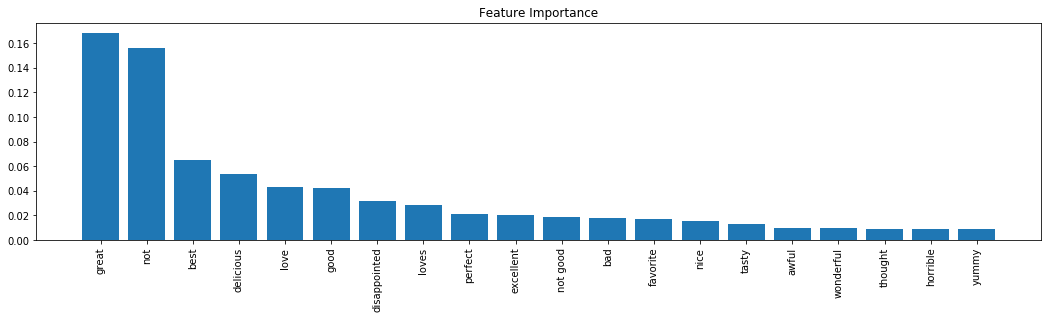

In [45]:
feature_imp_values = clf.feature_importances_
tfidf_features_names = tfidf_model.get_feature_names()

indices = np.argsort(feature_imp_values)[::-1]
names = [tfidf_features_names[i] for i in indices]

# Create plot
plt.figure(figsize=(18,4))
plt.title("Feature Importance")
# Add bars
plt.bar(range(20), feature_imp_values[indices][:20])
# Add feature names as x-axis labels
plt.xticks(range(20), names[:20], rotation=90)
plt.show()

### [5.2.2] Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

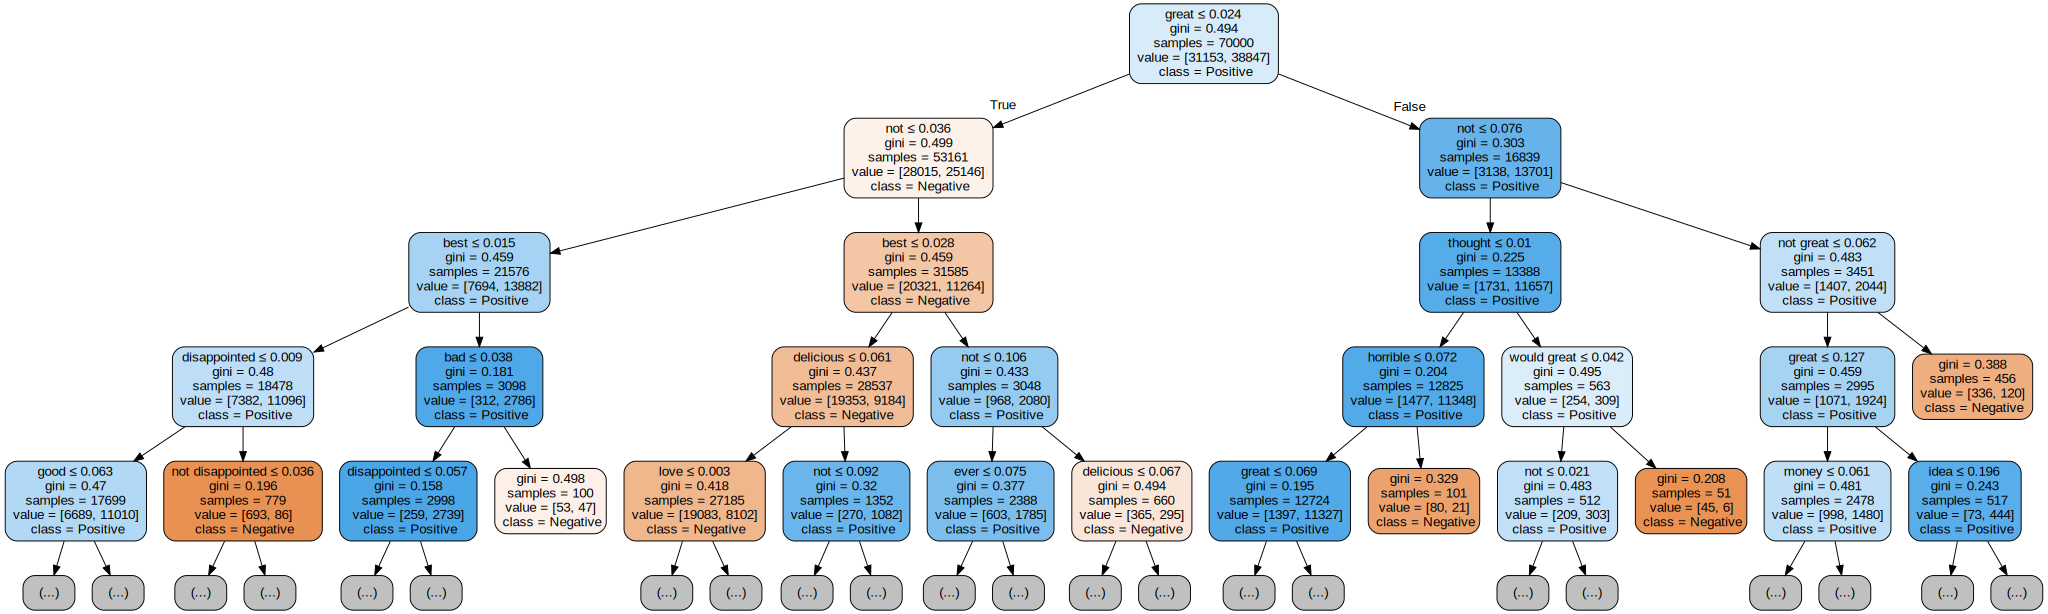

In [46]:
dot_data = export_graphviz(clf, out_file=None, max_depth=4,
                           feature_names=tfidf_features_names,
                           class_names=["Negative", "Positive"],
                           filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)  
graph.render('graphviz-tfidf')
graph 

## [5.3] Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

In [47]:
list_of_sent_train = []
list_of_sent_test = []

for sent in x_train:
    list_of_sent_train.append(sent.split())
for sent in x_test:
    list_of_sent_test.append(sent.split())
    
w2v_model=Word2Vec(list_of_sent_train,min_count=5,size=50)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  16878
sample words  ['cranberries', 'rita', 'smokiness', 'particularly', 'drier', 'exiting', 'cellulose', 'degrade', 'unwilling', 'lately', 'canal', 'lengths', 'swore', 'crunchiest', 'grief', 'messed', 'song', 'dissolving', 'sacrifice', 'smile', 'inedible', 'brain', 'beginners', 'bottles', 'drugs', 'runner', 'stunned', 'pikes', 'ripen', 'marvel', 'morsel', 'pong', 'undrinkable', 'canola', 'gratification', 'superbly', 'majority', 'grower', 'carnation', 'hirts', 'travels', 'puking', 'refried', 'hurry', 'agreement', 'claw', 'mousse', 'supervise', 'emperor', 'translucent']


In [48]:
# compute average word2vec for each review for train data 
avgw2v_train = [] # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_train, ascii=True, desc="Training Set W2V"): # for each review/sentence
    sent_vec = np.zeros(50)
    cnt_words = 0 # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    avgw2v_train.append(sent_vec)
    
# compute average word2vec for each review for test data 
avgw2v_test = [] # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_test, ascii=True, desc="Testing Set W2V"): # for each review/sentence
    sent_vec = np.zeros(50) 
    cnt_words = 0 # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    avgw2v_test.append(sent_vec)

Testing Set W2V: 100%|##########| 30000/30000 [07:44<00:00, 64.52it/s]


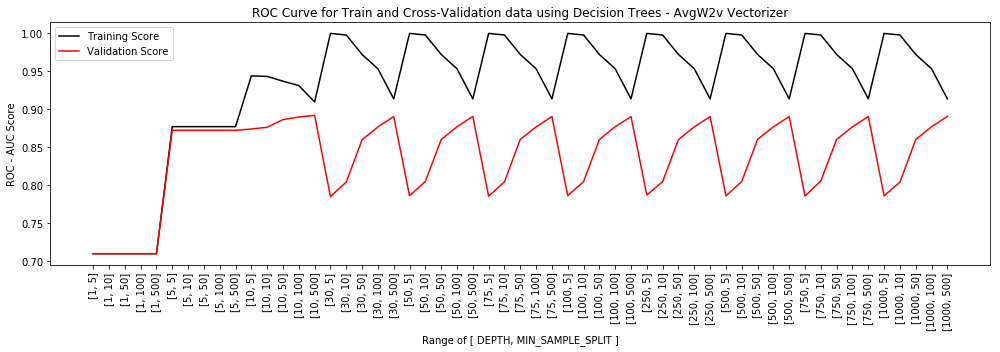

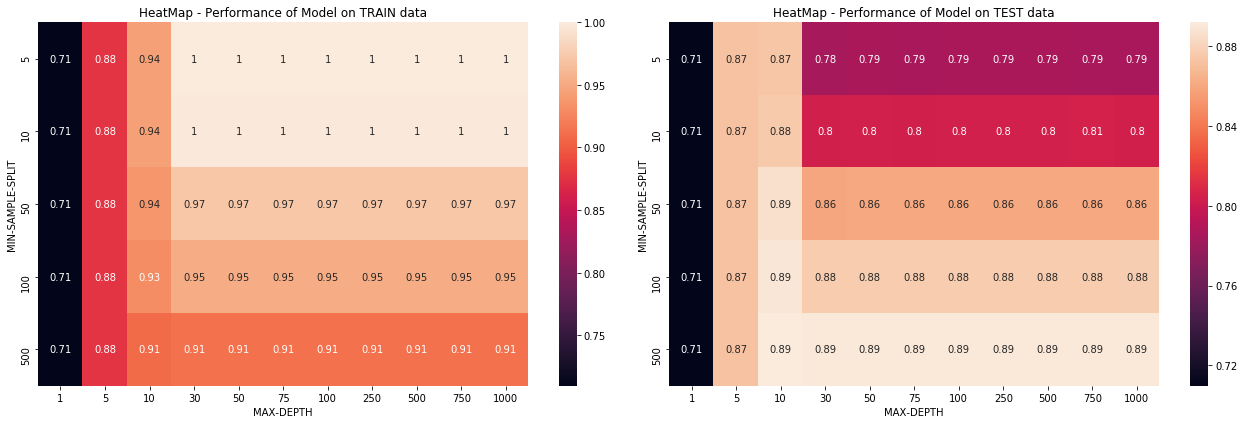

In [49]:
# Applying DecisionTreeClassifier using GridSearch CV=10
dtc = DecisionTreeClassifier()
parameters = {'max_depth': depth_range, 'min_samples_split': min_split_range}
clf = GridSearchCV(dtc, parameters, cv=10, scoring = 'roc_auc', return_train_score=True)
clf.fit(avgw2v_train, y_train)

mean_train_score = clf.cv_results_['mean_train_score']
mean_test_score = clf.cv_results_['mean_test_score']

param_arr = list(map(lambda obj: list([obj['max_depth'], obj['min_samples_split']]), clf.cv_results_['params']))

plt.figure(figsize=(14, 5))
#Plot mean accuracy for train and cv set scores
plt.plot(tot_hyp_length, mean_train_score, label='Training Score', color='black')
plt.plot(tot_hyp_length, mean_test_score, label='Validation Score', color='red')
plt.xticks(tot_hyp_length, param_arr, rotation='vertical')

# Create plot
plt.title("ROC Curve for Train and Cross-Validation data using Decision Trees - AvgW2v Vectorizer")
plt.xlabel("Range of [ DEPTH, MIN_SAMPLE_SPLIT ]")
plt.ylabel("ROC - AUC Score")
plt.tight_layout()
plt.legend(loc="best")

m_train_score = clf.cv_results_['mean_train_score'].reshape((len(depth_range), len(min_split_range))).T
m_test_score = clf.cv_results_['mean_test_score'].reshape((len(depth_range), len(min_split_range))).T

plt.figure(figsize=(18,6))
plt.subplot(1, 2, 1)
plt.title('HeatMap - Performance of Model on TRAIN data')
ax1 = sns.heatmap(m_train_score, annot=True, xticklabels=depth_range, yticklabels=min_split_range)
ax1.set_xlabel('MAX-DEPTH')
ax1.set_ylabel('MIN-SAMPLE-SPLIT')

plt.subplot(1, 2, 2)
plt.title('HeatMap - Performance of Model on TEST data')
ax2 = sns.heatmap(m_test_score, annot=True, xticklabels=depth_range, yticklabels=min_split_range)
ax2.set_xlabel('MAX-DEPTH')
ax2.set_ylabel('MIN-SAMPLE-SPLIT')

plt.tight_layout()
plt.show()

Optimal Depth: 10 with Min_Split: 500 with AUC: 89.47%


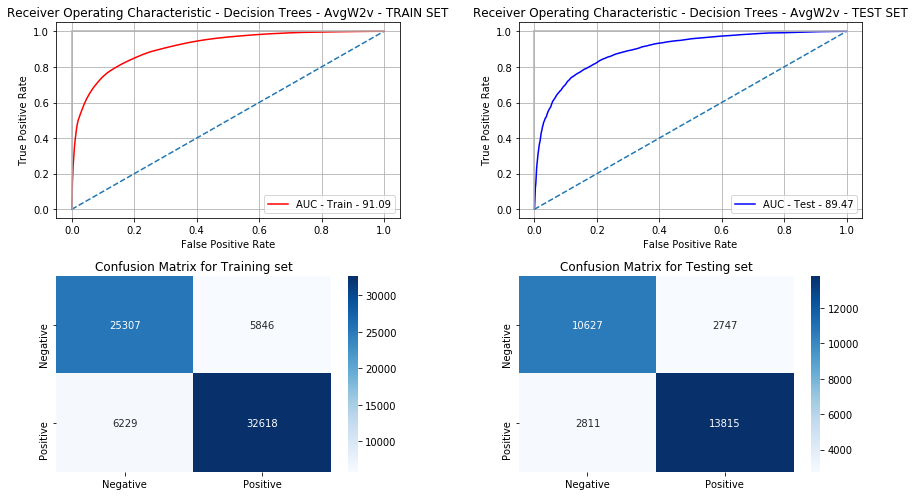

In [50]:
optimal_depth = clf.best_params_['max_depth']
optimal_min_split = clf.best_params_['min_samples_split']

clf = DecisionTreeClassifier(max_depth = optimal_depth, min_samples_split = optimal_min_split)
clf.fit(avgw2v_train, y_train)

# Get predicted values for test data
pred_train = clf.predict(avgw2v_train)
pred_test = clf.predict(avgw2v_test)
pred_proba_train = clf.predict_proba(avgw2v_train)[:,1]
pred_proba_test = clf.predict_proba(avgw2v_test)[:,1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, pred_proba_train, pos_label=1)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, pred_proba_test, pos_label=1)
conf_mat_train = confusion_matrix(y_train, pred_train, labels=[0, 1])
conf_mat_test = confusion_matrix(y_test, pred_test, labels=[0, 1])
f1_sc = f1_score(y_test, pred_test, average='binary', pos_label=1)
auc_sc_train = auc(fpr_train, tpr_train)
auc_sc = auc(fpr_test, tpr_test)

print("Optimal Depth: {} with Min_Split: {} with AUC: {:.2f}%".format(optimal_depth, optimal_min_split, float(auc_sc*100)))
#Saving the report in a global variable
result_report = result_report.append({'VECTORIZER': 'Avg-W2V',
                                      'MAX-DEPTH(HYPERPARAMETER)': optimal_depth,
                                      'MIN_SPLIT(HYPERPARAMETER)': optimal_min_split,
                                      'DATASET-SIZE': '{0:,.0f}'.format(int(min_final.shape[0])),
                                      'F1_SCORE': f1_sc, 
                                      'AUC': auc_sc
                                     }, ignore_index=True)


plt.figure(figsize=(13,7))
# Plot ROC curve for training set
plt.subplot(2, 2, 1)
plt.title('Receiver Operating Characteristic - Decision Trees - AvgW2v - TRAIN SET')
plt.plot(fpr_train, tpr_train, color='red', label='AUC - Train - {:.2f}'.format(float(auc_sc_train * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc='best')

# Plot ROC curve for test set
plt.subplot(2, 2, 2)
plt.title('Receiver Operating Characteristic - Decision Trees - AvgW2v - TEST SET')
plt.plot(fpr_test, tpr_test, color='blue', label='AUC - Test - {:.2f}'.format(float(auc_sc * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc='best')

#Plotting the confusion matrix for train
plt.subplot(2, 2, 3)
plt.title('Confusion Matrix for Training set')
df_cm = pd.DataFrame(conf_mat_train, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

#Plotting the confusion matrix for test
plt.subplot(2, 2, 4)
plt.title('Confusion Matrix for Testing set')
df_cm = pd.DataFrame(conf_mat_test, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

plt.tight_layout()
plt.show()

## [5.4] Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

In [51]:
model = TfidfVectorizer()
model.fit(x_train)

#Creating the TFIDF W2V Training Set
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidfw2v_train = []; 
tfidfw2v_test = []; 

for sent in tqdm(list_of_sent_train, ascii=True, desc='Training Set for TFIDF W2V'): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidfw2v_train.append(sent_vec)
    
for sent in tqdm(list_of_sent_test, ascii=True, desc='Testing Set for TFIDF W2V'): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidfw2v_test.append(sent_vec)

Testing Set for TFIDF W2V: 100%|##########| 30000/30000 [22:17<00:00, 22.43it/s] 


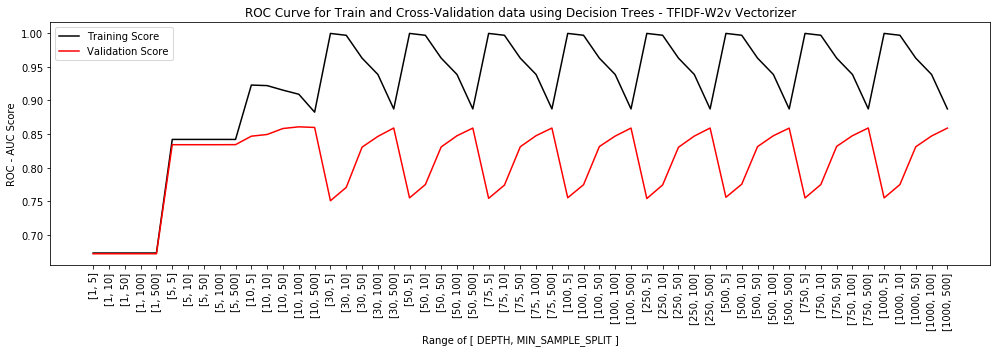

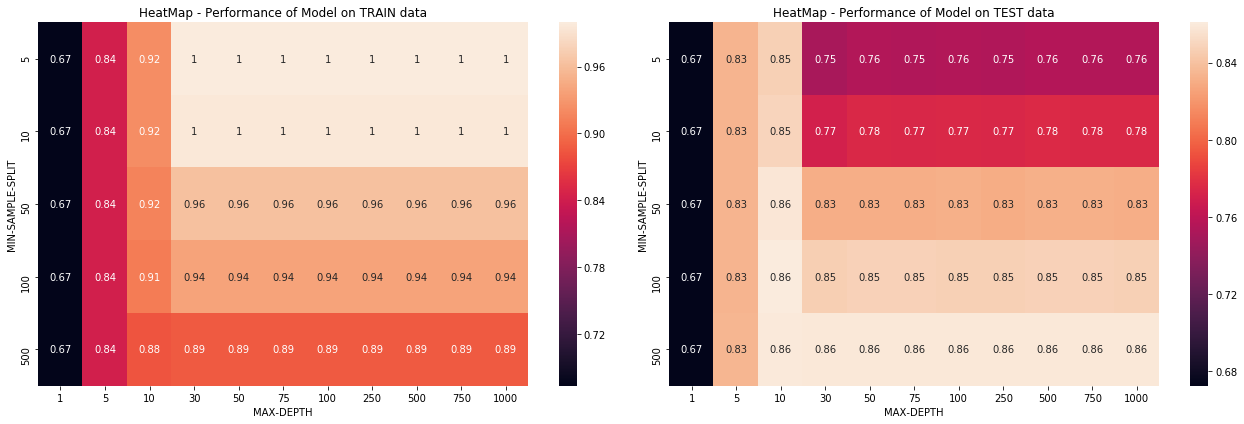

In [52]:
# Applying DecisionTreeClassifier using GridSearch CV=10
dtc = DecisionTreeClassifier()
parameters = {'max_depth': depth_range, 'min_samples_split': min_split_range}
clf = GridSearchCV(dtc, parameters, cv=10, scoring = 'roc_auc', return_train_score=True)
clf.fit(tfidfw2v_train, y_train)

mean_train_score = clf.cv_results_['mean_train_score']
mean_test_score = clf.cv_results_['mean_test_score']

param_arr = list(map(lambda obj: list([obj['max_depth'], obj['min_samples_split']]), clf.cv_results_['params']))

plt.figure(figsize=(14, 5))
#Plot mean accuracy for train and cv set scores
plt.plot(tot_hyp_length, mean_train_score, label='Training Score', color='black')
plt.plot(tot_hyp_length, mean_test_score, label='Validation Score', color='red')
plt.xticks(tot_hyp_length, param_arr, rotation='vertical')

# Create plot
plt.title("ROC Curve for Train and Cross-Validation data using Decision Trees - TFIDF-W2v Vectorizer")
plt.xlabel("Range of [ DEPTH, MIN_SAMPLE_SPLIT ]")
plt.ylabel("ROC - AUC Score")
plt.tight_layout()
plt.legend(loc="best")

m_train_score = clf.cv_results_['mean_train_score'].reshape((len(depth_range), len(min_split_range))).T
m_test_score = clf.cv_results_['mean_test_score'].reshape((len(depth_range), len(min_split_range))).T

plt.figure(figsize=(18,6))
plt.subplot(1, 2, 1)
plt.title('HeatMap - Performance of Model on TRAIN data')
ax1 = sns.heatmap(m_train_score, annot=True, xticklabels=depth_range, yticklabels=min_split_range)
ax1.set_xlabel('MAX-DEPTH')
ax1.set_ylabel('MIN-SAMPLE-SPLIT')

plt.subplot(1, 2, 2)
plt.title('HeatMap - Performance of Model on TEST data')
ax2 = sns.heatmap(m_test_score, annot=True, xticklabels=depth_range, yticklabels=min_split_range)
ax2.set_xlabel('MAX-DEPTH')
ax2.set_ylabel('MIN-SAMPLE-SPLIT')

plt.tight_layout()
plt.show()

Optimal Depth: 10 with Min_Split: 100 with AUC: 86.50%


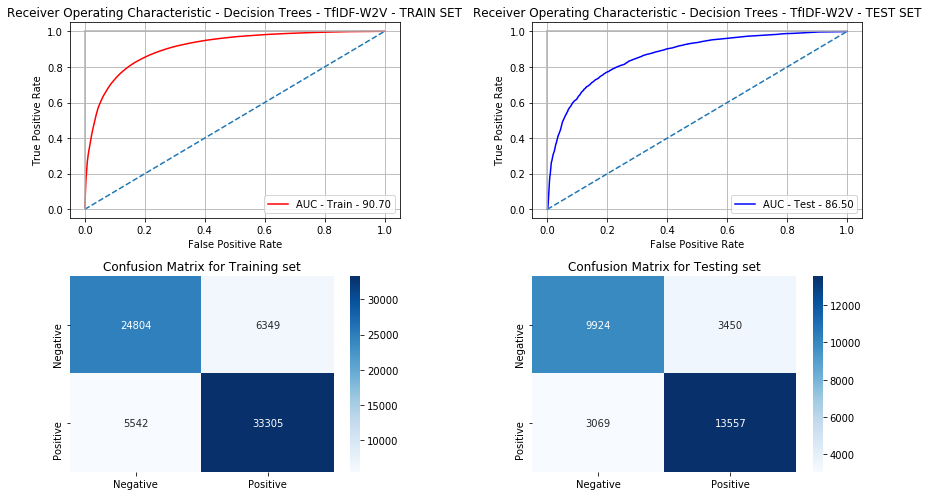

In [53]:
optimal_depth = clf.best_params_['max_depth']
optimal_min_split = clf.best_params_['min_samples_split']

clf = DecisionTreeClassifier(max_depth = optimal_depth, min_samples_split = optimal_min_split)
clf.fit(tfidfw2v_train, y_train)

# Get predicted values for test data
pred_train = clf.predict(tfidfw2v_train)
pred_test = clf.predict(tfidfw2v_test)
pred_proba_train = clf.predict_proba(tfidfw2v_train)[:,1]
pred_proba_test = clf.predict_proba(tfidfw2v_test)[:,1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, pred_proba_train, pos_label=1)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, pred_proba_test, pos_label=1)
conf_mat_train = confusion_matrix(y_train, pred_train, labels=[0, 1])
conf_mat_test = confusion_matrix(y_test, pred_test, labels=[0, 1])
f1_sc = f1_score(y_test, pred_test, average='binary', pos_label=1)
auc_sc_train = auc(fpr_train, tpr_train)
auc_sc = auc(fpr_test, tpr_test)

print("Optimal Depth: {} with Min_Split: {} with AUC: {:.2f}%".format(optimal_depth, optimal_min_split, float(auc_sc*100)))
#Saving the report in a global variable
result_report = result_report.append({'VECTORIZER': 'TFIDF-W2V',
                                      'MAX-DEPTH(HYPERPARAMETER)': optimal_depth,
                                      'MIN_SPLIT(HYPERPARAMETER)': optimal_min_split,
                                      'DATASET-SIZE': '{0:,.0f}'.format(int(min_final.shape[0])),
                                      'F1_SCORE': f1_sc, 
                                      'AUC': auc_sc
                                     }, ignore_index=True)


plt.figure(figsize=(13,7))
# Plot ROC curve for training set
plt.subplot(2, 2, 1)
plt.title('Receiver Operating Characteristic - Decision Trees - TfIDF-W2V - TRAIN SET')
plt.plot(fpr_train, tpr_train, color='red', label='AUC - Train - {:.2f}'.format(float(auc_sc_train * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc='best')

# Plot ROC curve for test set
plt.subplot(2, 2, 2)
plt.title('Receiver Operating Characteristic - Decision Trees - TfIDF-W2V - TEST SET')
plt.plot(fpr_test, tpr_test, color='blue', label='AUC - Test - {:.2f}'.format(float(auc_sc * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc='best')

#Plotting the confusion matrix for train
plt.subplot(2, 2, 3)
plt.title('Confusion Matrix for Training set')
df_cm = pd.DataFrame(conf_mat_train, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

#Plotting the confusion matrix for test
plt.subplot(2, 2, 4)
plt.title('Confusion Matrix for Testing set')
df_cm = pd.DataFrame(conf_mat_test, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

plt.tight_layout()
plt.show()

# [6] Conclusions

In [54]:
result_report

,VECTORIZER,DATASET-SIZE,MAX-DEPTH(HYPERPARAMETER),MIN_SPLIT(HYPERPARAMETER),F1_SCORE,AUC
0,Bag of Words(BoW),"100,000",30,500,0.827403,0.881913
1,TF-IDF,"100,000",30,500,0.825141,0.875343
2,Avg-W2V,"100,000",10,500,0.832530,0.894680
3,TFIDF-W2V,"100,000",10,100,0.806173,0.865033
